Objective:
- Predict the salary of NFL players

Notable Oversights:
- Lack of historical data

In [2634]:
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

Step 1: Gather player details data from sportsdata.io
- This website requires an API key which can be obtained by making a free account. 
- In their website, you can choose which database you want to access

In [2635]:
# # TODO: hide API key
API_KEY = '991b8171dd5b458ab8b0c839006b880c' 
SPORTSDATA_URL = 'https://api.sportsdata.io/v3/nfl/scores/json/Players?key={}'.format(API_KEY)

if not os.path.exists('nfl_data.csv'):
    print('Requesting NFL players physical data...')
    response = requests.get(SPORTSDATA_URL)
    if response.status_code == 200:
        data = response.json()
        df_nfl = pd.DataFrame.from_dict(data)
        df_nfl.to_csv('nfl_data.csv', index=False)
    else:
       print(', response.status_code, response.reason')
else:
    df_nfl = pd.read_csv('nfl_data.csv')

View available columns and remove unnecessary columns

In [2636]:
df_nfl.head(10)

,PlayerID,Team,Number,FirstName,LastName,Position,Status,Height,Weight,BirthDate,College,Experience,FantasyPosition,Active,PositionCategory,Name,Age,ExperienceString,BirthDateString,PhotoUrl,ByeWeek,UpcomingGameOpponent,UpcomingGameWeek,ShortName,AverageDraftPosition,DepthPositionCategory,DepthPosition,DepthOrder,DepthDisplayOrder,CurrentTeam,CollegeDraftTeam,CollegeDraftYear,CollegeDraftRound,CollegeDraftPick,IsUndraftedFreeAgent,HeightFeet,HeightInches,UpcomingOpponentRank,UpcomingOpponentPositionRank,CurrentStatus,UpcomingSalary,FantasyAlarmPlayerID,SportRadarPlayerID,RotoworldPlayerID,RotoWirePlayerID,StatsPlayerID,SportsDirectPlayerID,XmlTeamPlayerID,FanDuelPlayerID,DraftKingsPlayerID,YahooPlayerID,InjuryStatus,InjuryBodyPart,InjuryStartDate,InjuryNotes,FanDuelName,DraftKingsName,YahooName,FantasyPositionDepthOrder,InjuryPractice,InjuryPracticeDescription,DeclaredInactive,UpcomingFanDuelSalary,UpcomingDraftKingsSalary,UpcomingYahooSalary,TeamID,GlobalTeamID,FantasyDraftPlayerID,FantasyDraftName,UsaTodayPlayerID,UsaTodayHeadshotUrl,UsaTodayHeadshotNoBackgroundUrl,UsaTodayHeadshotUpdated,UsaTodayHeadshotNoBackgroundUpdated
0,430,NaN,NaN,Sam,Koch,P,Inactive,"6'1""",222,1982-08-13T00:00:00,Nebraska,12,P,False,ST,Sam Koch,41.00,17th Season,"August 13, 1982",https://s3-us-west-2.amazonaws.com/static.fant...,NaN,TEN,0,S.Koch,NaN,Scrambled,Scrambled,NaN,NaN,NaN,BAL,2006.00,3.00,138.00,False,6,1,7,21.00,Scrambled,NaN,302805.00,544e4159-3da3-47ad-866c-bf48d7634f25,NaN,7073.00,214953.00,11211.00,8642.00,NaN,NaN,7952.00,Scrambled,Scrambled,NaN,Scrambled,NaN,NaN,NaN,NaN,Scrambled,Scrambled,False,NaN,NaN,NaN,NaN,0,NaN,NaN,8253808.00,http://cdn.usatsimg.com/api/download/?imageID=...,http://cdn.usatsimg.com/api/download/?imageID=...,2021-08-15T21:54:16,2021-08-18T20:29:39
1,549,ARI,5.00,Matt,Prater,K,Active,"5'10""",201,1984-08-10T00:00:00,Central Florida,12,K,True,ST,Matt Prater,39.00,17th Season,"August 10, 1984",https://s3-us-west-2.amazonaws.com/static.fant...,14.00,SF,15,M.Prater,266.00,Scrambled,Scrambled,0.00,136.00,ARI,DET,2006.00,NaN,NaN,True,5,10,2,4.00,Scrambled,4910.00,300720.00,67f5e782-f91c-4536-9818-cf4a0e7e821d,4502.00,5051.00,218237.00,4014.00,8751.00,6782.00,218237.00,8565.00,Scrambled,Scrambled,NaN,Scrambled,Matt Prater,Matt Prater,Matt Prater,0.00,Scrambled,Scrambled,False,NaN,NaN,NaN,1.00,1,NaN,NaN,8274209.00,http://cdn.usatsimg.com/api/download/?imageID=...,http://cdn.usatsimg.com/api/download/?imageID=...,2023-11-22T11:25:08,2023-11-27T17:01:23
2,611,CLE,15.00,Joe,Flacco,QB,Active,"6'6""",245,1985-01-16T00:00:00,Delaware,11,QB,True,OFF,Joe Flacco,38.00,16th Season,"January 16, 1985",https://s3-us-west-2.amazonaws.com/static.fant...,5.00,CHI,15,J.Flacco,368.30,Scrambled,Scrambled,0.00,0.00,CLE,BAL,2008.00,0.00,12.00,False,6,6,12,14.00,Scrambled,3751.00,302714.00,64797df2-efd3-4b27-86ee-1d48f7edb09f,4677.00,5648.00,216342.00,12802.00,10384.00,6714.00,216342.00,8795.00,Scrambled,Scrambled,NaN,Scrambled,Joe Flacco,Joe Flacco,Joe Flacco,0.00,Scrambled,Scrambled,False,4842.00,3751.00,18.00,8.00,8,216342.00,Joe Flacco,8322402.00,http://cdn.usatsimg.com/api/download/?imageID=...,http://cdn.usatsimg.com/api/download/?imageID=...,2020-08-22T12:33:40,2022-09-07T20:50:27
3,732,NaN,NaN,Matt,Ryan,QB,Inactive,"6'4""",220,1985-05-17T00:00:00,Boston College,11,QB,False,OFF,Matt Ryan,38.00,16th Season,"May 17, 1985",https://s3-us-west-2.amazonaws.com/static.fant...,NaN,HOU,0,M.Ryan,525.80,Scrambled,Scrambled,NaN,NaN,NaN,ATL,2008.00,0.00,1.00,False,6,4,13,17.00,Scrambled,NaN,302726.00,7e648a0b-fdc8-4661-a587-5826f2cac11b,4637.00,5610.00,216263.00,12152.00,10265.00,6616.00,216263.00,8780.00,Scrambled,Scrambled,NaN,Scrambled,Matt Ryan,Matt Ryan,Matt Ryan,NaN,Scrambled,Scrambled,False,NaN,NaN,NaN,NaN,0,216263.00,Matt Ryan,8299794.00,http://cdn.usatsimg.com/api/download/?imageID=...,http://cdn.usatsimg.com/api/download/?imageID=...,2022-09-01T10:31:43,2022-01-19T01:13:56
4,1410,NaN,NaN,Robbie,Gould,K,Inactive,"6'0""",190,1982-12-06T00:00

After looking into the CSV file, we will remove unnecessary columns

In [2637]:
cols_to_drop = ["PlayerID", "Number", "FirstName", "LastName", "FantasyPosition", 
                "PhotoUrl", "ByeWeek", "UpcomingGameOpponent", "UpcomingGameWeek", 
                "ShortName", "AverageDraftPosition", "DepthPositionCategory", 
                "DepthPosition", "DepthOrder", "DepthDisplayOrder", "CurrentTeam", 
                "CollegeDraftTeam", "CollegeDraftYear", "CollegeDraftRound", 
                "CollegeDraftPick", "IsUndraftedFreeAgent", 'BirthDate', 'BirthDateString',
                "UpcomingOpponentRank", "UpcomingOpponentPositionRank", "CurrentStatus",
                "FantasyAlarmPlayerID", "SportRadarPlayerID", 'UpcomingSalary',
                "RotoworldPlayerID", "RotoWirePlayerID", "StatsPlayerID", "SportsDirectPlayerID", 
                "XmlTeamPlayerID", "FanDuelPlayerID", "DraftKingsPlayerID", "YahooPlayerID", 
                "InjuryStatus", "InjuryBodyPart", "InjuryStartDate", "InjuryNotes", 
                "FanDuelName", "DraftKingsName", "YahooName", "FantasyPositionDepthOrder", 
                "InjuryPractice", "InjuryPracticeDescription", "DeclaredInactive", 
                "UpcomingFanDuelSalary", "UpcomingDraftKingsSalary", "UpcomingYahooSalary", 
                "TeamID", "GlobalTeamID", "FantasyDraftPlayerID", "FantasyDraftName", 
                "UsaTodayPlayerID", "UsaTodayHeadshotUrl", "UsaTodayHeadshotNoBackgroundUrl", 
                "UsaTodayHeadshotUpdated", "UsaTodayHeadshotNoBackgroundUpdated"]
df_nfl = df_nfl.drop(cols_to_drop, axis=1)

Step 2: Gather salary data
- Using the selector gadget and inspecting the webpage, we are able to specifiy only the elements of interest.

In [2638]:
SALARY_URL = 'https://www.spotrac.com/nfl/salaries/breakdown/'

if not os.path.exists('nfl_salaries.csv'):
    print('Requesting NFL salary data...')
    response = requests.get(SALARY_URL)
    if response.status_code == 200:
        soup = bs(response.content, 'html.parser')
        players_html = soup.select(selector='td.player a')
        salaries_html = soup.select(selector='table tr .xs-hide+ td.right span.cap.info')
        players = [player.string for player in players_html]
        salaries = [salary.string for salary in salaries_html]
        df_salaries = pd.DataFrame({'Name': players, 'Salary': salaries})
        df_salaries.to_csv('nfl_salaries.csv', index=False)
    else:
        print('Error:', response.status_code, response.reason)
else:
    df_salaries = pd.read_csv('nfl_salaries.csv')

Step 3: Import manually collected data from: https://www.espn.com/nfl/stats/player/_/view
*note: I attempted to gather this data utilizing the requests requests library but ran into 2 problems:
1) 403 error: Forbidden. I checked the robots.txt file and did not find any mention of nfl/stats/player. Thus I looked for a solution using a code snippet from stackoverflow (https://stackoverflow.com/questions/38489386/how-to-fix-403-forbidden-errors-when-calling-apis-using-python-requests).
2) The page contained a "Show more" button and the requests package would only get the first 50 entries. I could have looked into a Selenium solution but since the dataset wasnt that big, I ultimatly just copied and pasted the data into a CSV manually.

In [2639]:
df_passing = pd.read_csv('passing_stats.csv')
df_recieving = pd.read_csv('recieving_stats.csv')
df_rushing = pd.read_csv('rushing_stats.csv')
df_defense = pd.read_csv('defense_stats.csv')

df_game_stats = df_passing.merge(
    df_recieving, on='Name', how='outer').merge(
        df_rushing, on='Name', how='outer').merge(
            df_defense, on='Name', how='outer'
        )

df_game_stats = df_game_stats.fillna(0)

Step 4: Combine the datasets
- We will notice a drop in entries. This is mainly due to not having the salaries of every listed player between each dataset. For the names that do exist between each dataset, the Names (which is the column we are merging on) appear to be the same. I looked into edges cases of abbreviations and suffix's and I did not see signs of concern.
- Another observation is that the the df_nfl dataset contains much more entires. This is because it includes inactive players. 

In [2640]:
print(f'{len(df_nfl)=}')
print(f'{len(df_salaries)=}')
print(f'{len(df_game_stats)=}')
df = pd.merge(df_salaries, df_nfl, how='inner', on='Name')
df = df.merge(df_game_stats, how='inner', on='Name')

# Randomize the order of the rows as it is currenlty sorted by decending salary
# Use a random_state to get the same randomization each time so it doesnt affect the model
df = df.sample(frac=1, random_state=10).reset_index(drop=True) 
df = df.drop('Name', axis=1)
print(f'{len(df)=}')

len(df_nfl)=4154
len(df_salaries)=1086
len(df_game_stats)=1566
len(df)=780


Step 5: Data Pre-Processing

- Remove inactive players as we are only working with current players. 

__(After reviewing, this is a large oversight and I should have included much more historical data, and account for inflation when pre-processing the salaries)__

In [2641]:
df = df[df['Active']==True]
df = df.drop('Active', axis=1)

Check for missing values and their context to determine how we want to handle these

In [2642]:
nan_df = df.isna()
print(df.isnull().sum())

Salary                   6
Team                     0
Position                 0
Status                   0
Height                   0
Weight                   0
College                  1
Experience               0
PositionCategory         0
Age                      0
ExperienceString         0
HeightFeet               0
HeightInches             0
CMP%                     0
PassingYards             0
PassingYardsPerGame      0
PassingTouchDowns        0
RecievingYards           0
AvgRecievingYards        0
ReceivingTouchdowns      0
RecievingYardsPerGame    0
RushingYards             0
RushingTouchDowns        0
RushingYardsPerGame      0
SoloTackles              0
AssistedTackles          0
TotalTackles             0
dtype: int64


Firstly, we notice that Salary is missing for 6 players. This is crutial information for us to test on but since it is an unknown, we will drop these entries. 

In [2643]:
df[pd.isna(df['Salary'])]

,Salary,Team,Position,Status,Height,Weight,College,Experience,PositionCategory,Age,ExperienceString,HeightFeet,HeightInches,CMP%,PassingYards,PassingYardsPerGame,PassingTouchDowns,RecievingYards,AvgRecievingYards,ReceivingTouchdowns,RecievingYardsPerGame,RushingYards,RushingTouchDowns,RushingYardsPerGame,SoloTackles,AssistedTackles,TotalTackles
61,NaN,NYG,OLB,Active,"6'3""",260,Holy Cross,1,DEF,24.00,2nd Season,6,3,0.00,0,0.00,0.00,0,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00
145,NaN,PIT,LB,Active,"6'2""",237,Stanford,3,DEF,29.00,7th Season,6,2,0.00,0,0.00,0.00,0,0.00,0.00,0.00,0,0.00,0.00,2.00,2.00,4.00
202,NaN,DAL,ILB,Active,"6'2""",232,Alabama,3,DEF,28.00,6th Season,6,2,0.00,0,0.00,0.00,0,0.00,0.00,0.00,0,0.00,0.00,2.00,4.00,6.00
399,NaN,LAC,OLB,Active,"6'4""",250,Lane College,0,DEF,23.00,Rookie,6,4,0.00,0,0.00,0.00,0,0.00,0.00,0.00,0,0.00,0.00,0.00,1.00,1.00
456,NaN,JAX,DL,Active,"6'3""",299,Arkansas,1,DEF,29.00,3rd Season,6,3,0.00,0,0.00,0.00,0,0.00,0.00,0.00,0,0.00,0.00,3.00,12.00,15.00
724,NaN,DAL,DE,Active,"6'2""",260,Mississippi State,0,DEF,24.00,Rookie,6,2,0.00,0,0.00,0.00,0,0.00,0.00,0.00,0,0.00,0.00,2.00,0.00,2.00


In [2644]:
df = df.dropna(subset=['Salary'])
df['College'] = df['College'].fillna('None')
nan_df = df.isna()
print(df.isnull().sum())

Salary                   0
Team                     0
Position                 0
Status                   0
Height                   0
Weight                   0
College                  0
Experience               0
PositionCategory         0
Age                      0
ExperienceString         0
HeightFeet               0
HeightInches             0
CMP%                     0
PassingYards             0
PassingYardsPerGame      0
PassingTouchDowns        0
RecievingYards           0
AvgRecievingYards        0
ReceivingTouchdowns      0
RecievingYardsPerGame    0
RushingYards             0
RushingTouchDowns        0
RushingYardsPerGame      0
SoloTackles              0
AssistedTackles          0
TotalTackles             0
dtype: int64


Now we will make changes to the value types of each column to reflect the values they hold. This will allow us to manipulate the data in proper ways.

In [2645]:
df.dtypes

Salary                    object
Team                      object
Position                  object
Status                    object
Height                    object
Weight                     int64
College                   object
Experience                 int64
PositionCategory          object
Age                      float64
ExperienceString          object
HeightFeet                 int64
HeightInches               int64
CMP%                     float64
PassingYards              object
PassingYardsPerGame      float64
PassingTouchDowns        float64
RecievingYards            object
AvgRecievingYards        float64
ReceivingTouchdowns      float64
RecievingYardsPerGame    float64
RushingYards              object
RushingTouchDowns        float64
RushingYardsPerGame      float64
SoloTackles              float64
AssistedTackles          float64
TotalTackles             float64
dtype: object

In [2646]:
df['Team'] = df['Team'].astype('category')
df['Position'] = df['Position'].astype('category')
df['Status'] = df['Status'].astype('category')
df['Weight'] = df['Weight'].astype(int)
df['College'] = df['College'].astype('category')
df['PositionCategory'] = df['PositionCategory'].astype('category')
df['Age'] = df['Age'].astype(int)
df['RecievingYards'] = df['RecievingYards'].astype(int)
df['RushingYards'] = df['RushingYards'].astype(int)
df.dtypes


Salary                     object
Team                     category
Position                 category
Status                   category
Height                     object
Weight                      int32
College                  category
Experience                  int64
PositionCategory         category
Age                         int32
ExperienceString           object
HeightFeet                  int64
HeightInches                int64
CMP%                      float64
PassingYards               object
PassingYardsPerGame       float64
PassingTouchDowns         float64
RecievingYards              int32
AvgRecievingYards         float64
ReceivingTouchdowns       float64
RecievingYardsPerGame     float64
RushingYards                int32
RushingTouchDowns         float64
RushingYardsPerGame       float64
SoloTackles               float64
AssistedTackles           float64
TotalTackles              float64
dtype: object

Salary is currently a string and contains dollar signs and commas, we will remove those change the datatype.

In [2647]:
df['Salary'] = df['Salary'].str.replace('$', '')
df['Salary'] = df['Salary'].str.replace(',', '')
df['Salary'] = df['Salary'].astype(int)
print(df['Salary'])

0      1215000
1      9625000
2      1876593
3      1147108
4      4500000
        ...   
775    1260090
776    1933913
777     902677
778    6500000
779    2500000
Name: Salary, Length: 770, dtype: int32


Height is currently defined in 2 columns, Feet and Inches. To make the model interpret this better, we will convert Feet to inches and add this to the Inches column and create a new Height column. 

In [2648]:
df["Height"] = df["HeightFeet"]*12 + df['HeightInches']
df = df.drop(['HeightFeet', 'HeightInches'], axis=1)

In [2649]:
df.dtypes

Salary                      int32
Team                     category
Position                 category
Status                   category
Height                      int64
Weight                      int32
College                  category
Experience                  int64
PositionCategory         category
Age                         int32
ExperienceString           object
CMP%                      float64
PassingYards               object
PassingYardsPerGame       float64
PassingTouchDowns         float64
RecievingYards              int32
AvgRecievingYards         float64
ReceivingTouchdowns       float64
RecievingYardsPerGame     float64
RushingYards                int32
RushingTouchDowns         float64
RushingYardsPerGame       float64
SoloTackles               float64
AssistedTackles           float64
TotalTackles              float64
dtype: object

The Experience String column contains the number of seasons the player has in the league and is currently a string. Looking more into the data, the column contains a number and a string, we can extract this number and create a new column, Experience. We do also see a "Rookie" category, this we can convert to a 0 meaning the player has is in their 1st year in the league.

In [2650]:
df['ExperienceString'].head(10)

0     4th Season
1    11th Season
2     2nd Season
3     4th Season
4     7th Season
5     6th Season
6     3rd Season
7     7th Season
8     4th Season
9     6th Season
Name: ExperienceString, dtype: object

In [2651]:
df['Experience'] = df['ExperienceString'].str.extract('(\d+)')
df = df.drop('ExperienceString', axis=1)
df['Experience'] = df['Experience'].fillna(1).astype(int)
df['Experience'].unique()

array([ 4, 11,  2,  7,  6,  3,  9,  5,  8,  1, 12, 10, 13, 16, 14])

Validate our data entries by checking number of unique values on each column

In [2652]:
df.nunique(axis=0)

Salary                   467
Team                      32
Position                  17
Status                     4
Height                    13
Weight                   150
College                  176
Experience                15
PositionCategory           2
Age                       19
CMP%                       1
PassingYards               1
PassingYardsPerGame        1
PassingTouchDowns          1
RecievingYards             5
AvgRecievingYards          5
ReceivingTouchdowns        3
RecievingYardsPerGame      5
RushingYards               6
RushingTouchDowns          1
RushingYardsPerGame        6
SoloTackles               70
AssistedTackles           51
TotalTackles             105
dtype: int64

The statistics seem suspicious when they should be unique for each player.

In [2653]:
cols = ["CMP%", "PassingYards", "PassingYardsPerGame", "PassingTouchDowns", "RecievingYards", "AvgRecievingYards", "ReceivingTouchdowns", "RecievingYardsPerGame", "RushingYards", "RushingTouchDowns"]
for col in cols:
    print(col, df[col].unique())

CMP% [0.]
PassingYards [0]
PassingYardsPerGame [0.]
PassingTouchDowns [0.]
RecievingYards [  0   2  18 422  83]
AvgRecievingYards [ 0.   2.  18.  15.1  4.4]
ReceivingTouchdowns [0. 1. 5.]
RecievingYardsPerGame [ 0.   0.2  2.  46.9  7.5]
RushingYards [ 0  2 11  4  3 82]
RushingTouchDowns [0.]


After looking back at the data, some stats are only recorded for certain players based on what position they play. However, the lack of records for is still suspicous since more than 3 players have recieving touchdowns in the league. This may be a cause of an incomplete dataset.

Though in this case where there are 0 entries for certain columns, we can drop these.

In [2654]:
cols_to_drop2 = ["CMP%", "PassingYards", "PassingYardsPerGame", "PassingTouchDowns", "RushingTouchDowns"]
df = df.drop(cols_to_drop2, axis=1)

In [2655]:
df.dtypes

Salary                      int32
Team                     category
Position                 category
Status                   category
Height                      int64
Weight                      int32
College                  category
Experience                  int32
PositionCategory         category
Age                         int32
RecievingYards              int32
AvgRecievingYards         float64
ReceivingTouchdowns       float64
RecievingYardsPerGame     float64
RushingYards                int32
RushingYardsPerGame       float64
SoloTackles               float64
AssistedTackles           float64
TotalTackles              float64
dtype: object

Step 6: Encoding

Check which features are categorical that need to be converted to numbers and evaluate which method of encoding we should use.

In [2656]:
df.select_dtypes(include='category')

,Team,Position,Status,College,PositionCategory
0,CIN,CB,Active,Utah State,DEF
1,BUF,S,Active,Iowa,DEF
2,WAS,DT,Active,Alabama,DEF
3,CLE,DT,Active,Missouri,DEF
4,NE,DB,Active,Michigan,DEF
...,...,...,...,...,...
775,NO,CB,Active,Stanford,DEF
776,DET,DL,Active,Kentucky,DEF
777,DAL,S,Active,South Carolina,DEF
778,HOU,S,Active,Northern Illinois,DEF


In [2657]:
df['PositionCategory'].unique()

['DEF', 'OFF']
Categories (2, object): ['DEF', 'OFF']

Due to the binary representation of this feature, we can use label encoding, 0 for DEF and 1 for OFF

In [2658]:
df['PositionCategory'] = df['PositionCategory'].replace('DEF', 0)
df['PositionCategory'] = df['PositionCategory'].replace('OFF', 1)

In [2659]:
df['Status'].unique()

['Active', 'Injured Reserve', 'Non Football Injury', 'Suspended']
Categories (4, object): ['Active', 'Injured Reserve', 'Non Football Injury', 'Suspended']

Use one hot-encoding as it will not create too many extra features

In [2660]:
df_status = pd.get_dummies(df['Status'])
df = df.join(df_status)
df = df.drop('Status', axis=1)
df.head()


,Salary,Team,Position,Height,Weight,College,Experience,PositionCategory,Age,RecievingYards,AvgRecievingYards,ReceivingTouchdowns,RecievingYardsPerGame,RushingYards,RushingYardsPerGame,SoloTackles,AssistedTackles,TotalTackles,Active,Injured Reserve,Non Football Injury,Suspended
0,1215000,CIN,CB,70,190,Utah State,4,0,27,0,0.00,0.00,0.00,0,0.00,2.00,1.00,3.00,True,False,False,False
1,9625000,BUF,S,72,197,Iowa,11,0,32,0,0.00,0.00,0.00,0,0.00,32.00,12.00,44.00,True,False,False,False
2,1876593,WAS,DT,76,312,Alabama,2,0,25,0,0.00,0.00,0.00,0,0.00,1.00,2.00,3.00,True,False,False,False
3,1147108,CLE,DT,76,303,Missouri,4,0,26,0,0.00,0.00,0.00,0,0.00,11.00,5.00,16.00,True,False,False,False
4,4500000,NE,DB,71,217,Michigan,7,0,28,0,0.00,0.00,0.00,0,0.00,46.00,23.00,69.00,True,False,False,False


Remove the spaces in the column names created by the get_dummies function.

And convert the boolean values to integers

In [2661]:
df.columns = df.columns.str.replace(' ', '') 

Distribution of Positions

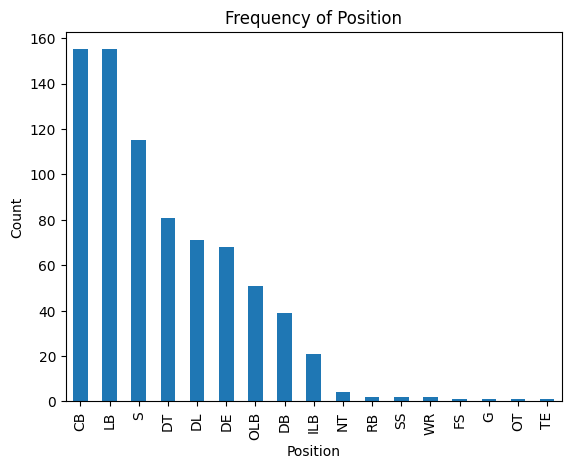

In [2662]:
freq = df["Position"].value_counts(sort=True)
ax = freq.plot.bar()
ax.set_title('Frequency of Position')
ax.set_xlabel("Position")
ax.set_ylabel("Count")
plt.show()

Due to the larger number of unique values in these categorical features, we will use Label Encoding to convert the category values to numbers

In [2663]:
le = LabelEncoder()

for col in ['Team', 'Position', 'College']:
    df[col] = le.fit_transform(df[col])
    print(df[col])

0       6
1       3
2      31
3       7
4      21
       ..
775    22
776    10
777     8
778    12
779    31
Name: Team, Length: 770, dtype: int32
0       0
1      13
2       4
3       4
4       1
       ..
775     0
776     3
777    13
778    13
779     0
Name: Position, Length: 770, dtype: int32
0      156
1       57
2        0
3       83
4       77
      ... 
775    133
776     64
777    124
778     98
779    129
Name: College, Length: 770, dtype: int32


Step 7: Visualizations - Exploratory Data Analysis

<Axes: title={'center': 'Distribution of Salaries'}, xlabel='Salary (mil)', ylabel='Frequency'>

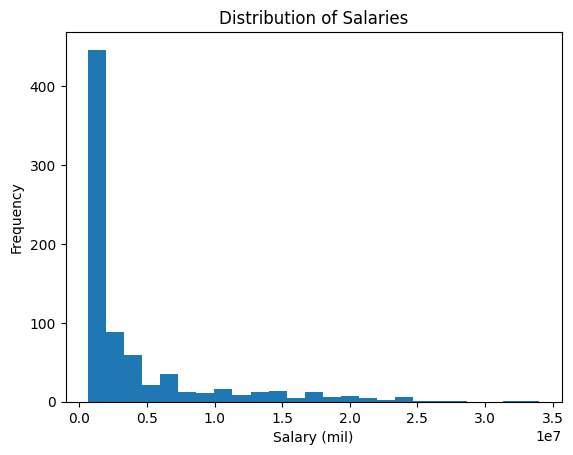

In [2664]:
df['Salary'].plot(kind='hist', bins=25, xlabel='Salary (mil)', title='Distribution of Salaries')

Salary seems to be biased towards less than $500,000

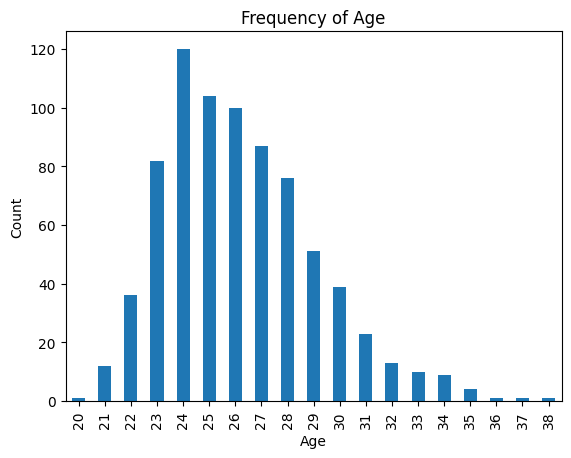

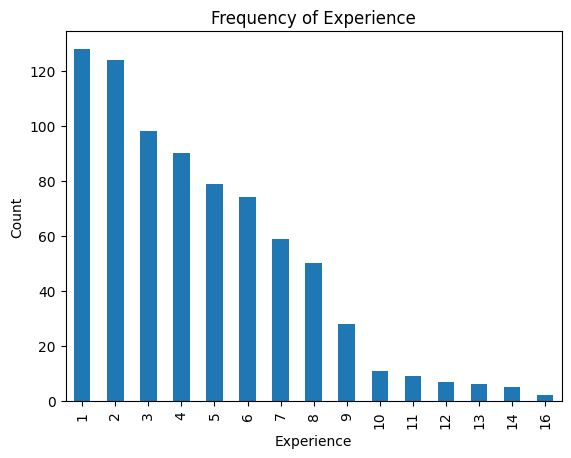

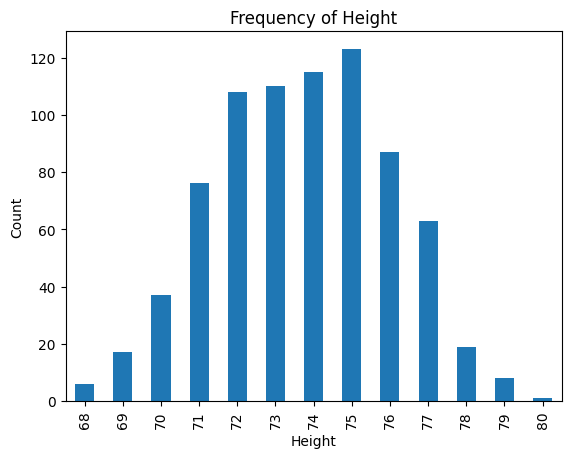

In [2665]:
freq = df["Age"].sort_values().value_counts(sort=False)
ax = freq.plot.bar()
ax.set_title('Frequency of Age')
ax.set_xlabel("Age")
ax.set_ylabel("Count")
plt.show()

freq = df["Experience"].sort_values().value_counts(sort=False)
ax = freq.plot.bar()
ax.set_title('Frequency of Experience')
ax.set_xlabel("Experience")
ax.set_ylabel("Count")
plt.show()

freq = df["Height"].sort_values().value_counts(sort=False)
ax = freq.plot.bar()
ax.set_title('Frequency of Height')
ax.set_xlabel("Height")
ax.set_ylabel("Count")
plt.show()

From these charts I see a skewed left distribution of age and experience which makes sense as newer players tend to replace older players. There is also a normal distribution of a players height.

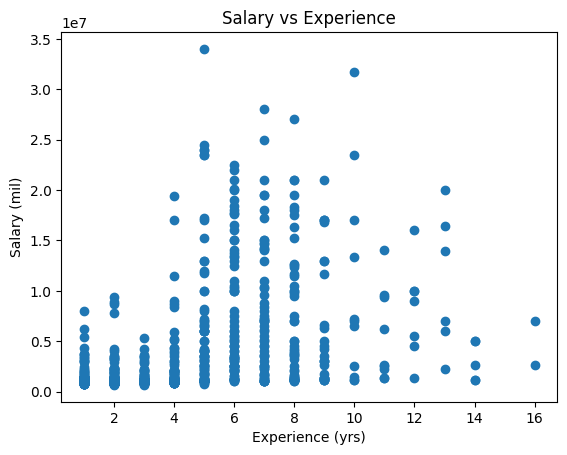

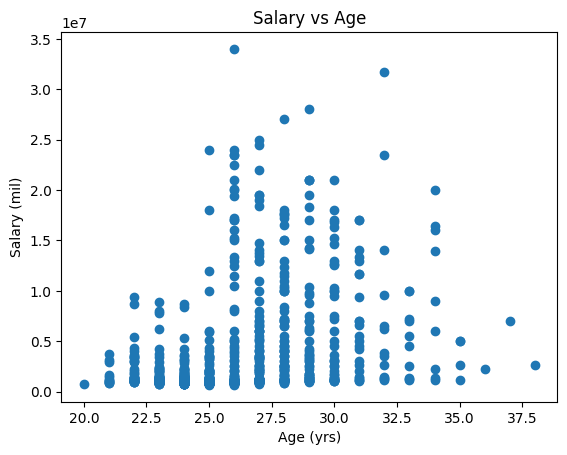

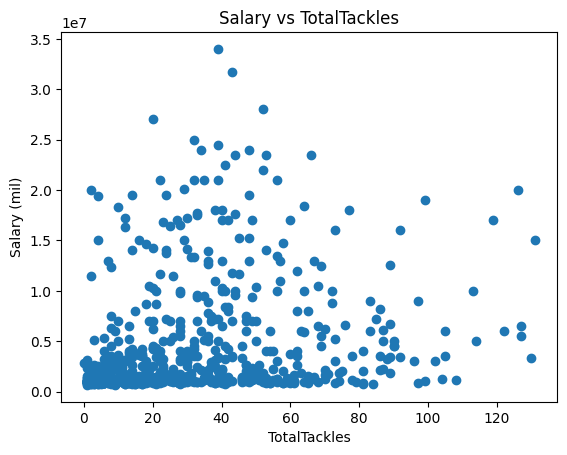

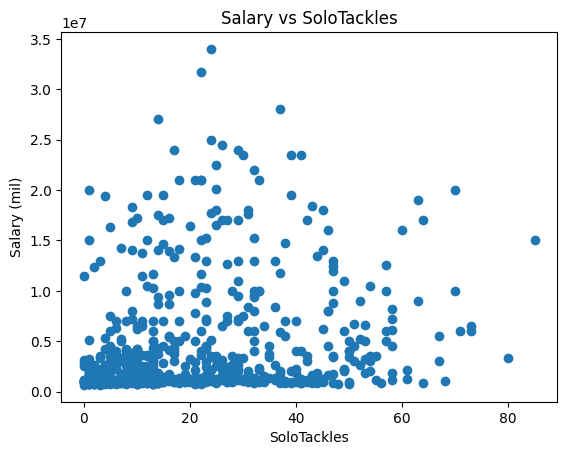

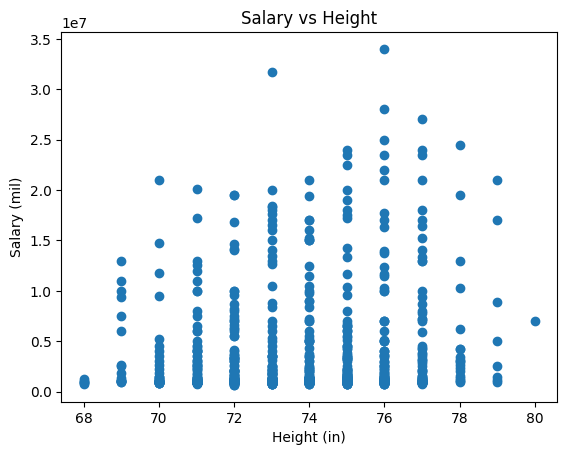

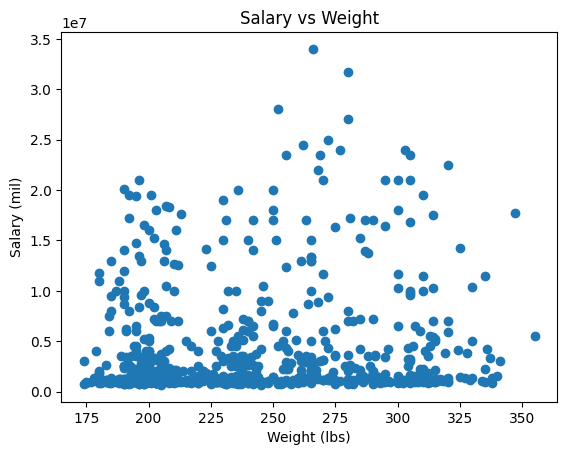

In [2666]:
plt.scatter(df['Experience'], df['Salary'])
plt.title('Salary vs Experience')
plt.xlabel('Experience (yrs)')
plt.ylabel('Salary (mil)')
plt.show()

plt.scatter(df['Age'], df['Salary'])
plt.title('Salary vs Age')
plt.xlabel('Age (yrs)')
plt.ylabel('Salary (mil)')
plt.show()

plt.scatter(df['TotalTackles'], df['Salary'])
plt.title('Salary vs TotalTackles')
plt.xlabel('TotalTackles')
plt.ylabel('Salary (mil)')
plt.show()

plt.scatter(df['SoloTackles'], df['Salary'])
plt.title('Salary vs SoloTackles')
plt.xlabel('SoloTackles')
plt.ylabel('Salary (mil)')
plt.show()

plt.scatter(df['Height'], df['Salary'])
plt.title('Salary vs Height')
plt.xlabel('Height (in)')
plt.ylabel('Salary (mil)')
plt.show()

plt.scatter(df['Weight'], df['Salary'])
plt.title('Salary vs Weight')
plt.xlabel('Weight (lbs)')
plt.ylabel('Salary (mil)')
plt.show()

From these charts, I can notice a normal distribution of salary vs age and experience with both of them seeming to be highly correlated to each other.

However, I do not see a correlation between any of the stats and their salaries. This can be due to the data being biased to one type of position. Lets look into this:

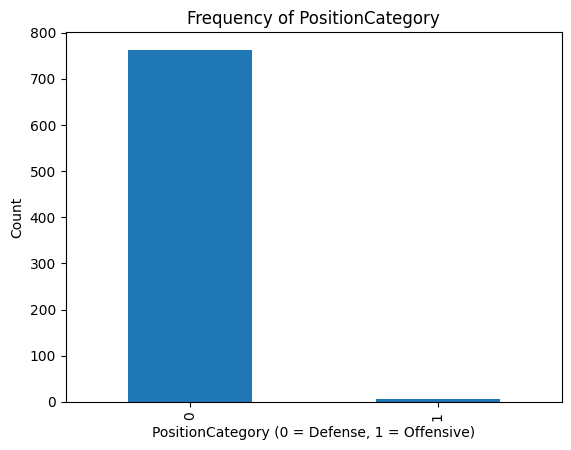

Number of Defense Players: 763
Number of Offensive Players: 7


In [2667]:
freq = df["PositionCategory"].sort_values().value_counts(sort=False)
ax = freq.plot.bar()
ax.set_title('Frequency of PositionCategory')
ax.set_xlabel("PositionCategory (0 = Defense, 1 = Offensive)")
ax.set_ylabel("Count")
plt.show()

print('Number of Defense Players:', len(df[df['PositionCategory'] == 0]))
print('Number of Offensive Players:', len(df[df['PositionCategory'] == 1]))

In [2668]:
print(df[df['PositionCategory'] == 1])

      Salary  Team  Position  Height  Weight  College  Experience PositionCategory  Age  RecievingYards  AvgRecievingYards  ReceivingTouchdowns  RecievingYardsPerGame  RushingYards  RushingYardsPerGame  SoloTackles  AssistedTackles  TotalTackles  Active  InjuredReserve  NonFootballInjury  Suspended
70   2667500    21        16      72     205      153          16                1   38               0               0.00                 0.00                   0.00             0                 0.00         2.00             1.00          3.00    True           False              False      False
156   882500     6        11      77     312        0           5                1   26               0               0.00                 0.00                   0.00             0                 0.00        14.00            24.00         38.00    True           False              False      False
174  2505000    18        12      71     220       81          11                1   33             

This is confirms the hypothesized bias. Though comparing the offensive players to the salary distribution chart may suggest that offensive players get paid more since all of these players are paid above the 500,000 with more than half of the population being above 1 million. 

To confirm or discover any other correlations, we can use a correlation heatmap.

<Axes: >

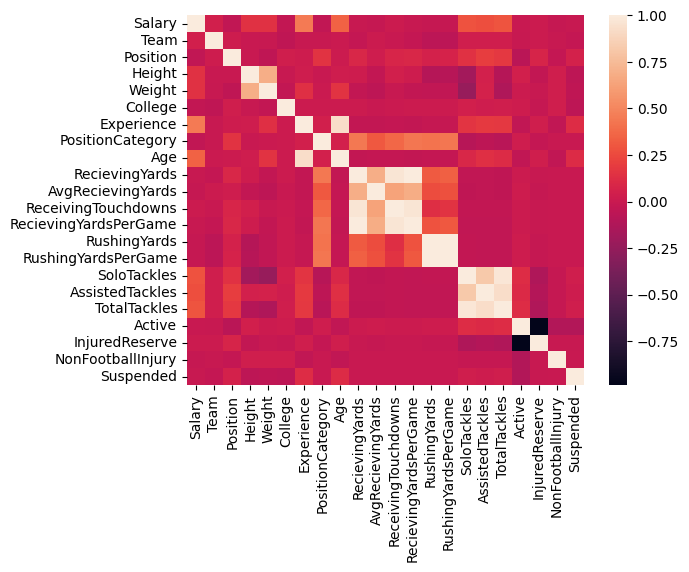

In [2669]:
sns.heatmap(df.corr())


At this point, the collected data does not seem to show any strong correlations to the salary.

The best path from here would be to find more data/revisit the collected data and look at how we can keep more data, or look for a different dataset. I have spent a good amount of time trying to fix the collected data, but due to time constraints, we will continue with the process. With this in mind, I do not expect the model to perform well.

For the future, I would definitly look into gathering more historical data and increasing the size of the data.

Step 8: Splitting the Data

In [2670]:
X = df.drop(["Salary"], axis=1)
y = df["Salary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(462, 21)
(308, 21)
(462,)
(308,)


Step 9: Scaling the Data

In order to increase the performance of our model, we will scale the data which will also help make better predictions.

We will scale all columns except the boolean/binary columns which are already scaled 0 and 1.

In [2671]:
print(X_train.head())
print(X_train.columns)

     Team  Position  Height  Weight  College  Experience PositionCategory  Age  RecievingYards  AvgRecievingYards  ReceivingTouchdowns  RecievingYardsPerGame  RushingYards  RushingYardsPerGame  SoloTackles  AssistedTackles  TotalTackles  Active  InjuredReserve  NonFootballInjury  Suspended
488    11         3      75     296       14           1                0   23               0               0.00                 0.00                   0.00             0                 0.00         9.00             5.00         14.00    True           False              False      False
717    10         8      72     240      114           3                0   24               0               0.00                 0.00                   0.00             0                 0.00        30.00            31.00         61.00    True           False              False      False
9      15        13      73     207      133           6                0   26               0               0.00              

In [2672]:
# Step 5

columns_to_scale = [
    'Team', 'Position', 'Height', 'Weight', 'College', 'Experience', 'Age', 
    'AvgRecievingYards', 'ReceivingTouchdowns', 'RecievingYardsPerGame', 
    'RushingYards', 'RushingYardsPerGame', 'SoloTackles', 'AssistedTackles', 
    'TotalTackles'
    ] 
    
columns_no_scale = [col for col in X_train.columns if col not in columns_to_scale]

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('no_scaler', 'passthrough', columns_no_scale)
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train = pd.DataFrame(X_train, columns=columns_to_scale + columns_no_scale)
X_test = pd.DataFrame(X_test, columns=columns_to_scale + columns_no_scale)
print(X_train)

     Team Position Height Weight College Experience   Age AvgRecievingYards ReceivingTouchdowns RecievingYardsPerGame RushingYards RushingYardsPerGame SoloTackles AssistedTackles TotalTackles PositionCategory RecievingYards Active InjuredReserve NonFootballInjury Suspended
0   -0.48    -0.57   0.58   1.37   -1.42      -1.16 -1.10             -0.07               -0.05                 -0.05        -0.05               -0.05       -0.57           -0.51        -0.57                0              0   True          False             False     False
1   -0.59     0.49  -0.71   0.06    0.54      -0.49 -0.76             -0.07               -0.05                 -0.05        -0.05               -0.05        0.73            2.16         1.32                0              0   True          False             False     False
2   -0.05     1.56  -0.28  -0.71    0.91       0.51 -0.09             -0.07               -0.05                 -0.05        -0.05               -0.05        2.21            0.42

Step 10: Implement LinearRegression Model

In [2673]:
lin_regr = LinearRegression()
 
lin_regr.fit(X_train, y_train)

y_pred = lin_regr.predict(X_test)

r_score = lin_regr.score(X_test, y_test)
mae = mean_absolute_error(y_true=y_test, y_pred=y_test)
mse = mean_squared_error(y_true=y_test, y_pred=y_test)
rmse = mean_squared_error(y_true=y_test, y_pred=y_test, squared=False)
 
print('R Score:', r_score)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

R Score: -0.19211703215710707
MAE: 0.0
MSE: 0.0
RMSE: 0.0


From this initial score, it seems as though the model was unable to find any trends to make proper predictions.

It appears that the other evaluation statistics are wrong/not implemented properly as 0 represents no error when there should be errors.

From here there are two methods I would like to try; RandomOverSampling to account for the biased data and use the RandomForestRegresor model. 

RandomOverSampler: Use the sampling_strategy parameter to target the minority group of data.

Step 11: Use RandomOverSampler to improve the model

In [2674]:
ros = RandomOverSampler(random_state=42, sampling_strategy='minority')

X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
print(X_train_ros.shape)

(473, 21)


Apply the Linear Regression Model again to see any changes

In [2675]:
lin_regr_ros = LinearRegression()
lin_regr_ros.fit(X_train_ros, y_train_ros)

y_pred = lin_regr_ros.predict(X_test)

r_score = lin_regr_ros.score(X_test, y_test)
mae = mean_absolute_error(y_true=y_test, y_pred=y_test)
mse = mean_squared_error(y_true=y_test, y_pred=y_test)
rmse = mean_squared_error(y_true=y_test, y_pred=y_test, squared=False)
 
 
print('R Score:', r_score)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

R Score: -0.1539899112810763
MAE: 0.0
MSE: 0.0
RMSE: 0.0


It seems the model improved marginally (less than half a percent).

Lets implement the random forest model

For reference: https://www.geeksforgeeks.org/random-forest-regression-in-python/

Step 12: Implement RandomForestRegressor Model

In [2676]:
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
regressor.fit(X_train_ros, y_train_ros)



c:\Users\louie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

Evaluating the model

In [2677]:
print(len(y_test))
print(len(X_test))

308
308


In [2682]:
 
# Make predictions on the same data or new data
predictions = regressor.predict(X_train_ros)

# Evaluating the model
oob_score = regressor.oob_score_
mse = mean_squared_error(y_train_ros, predictions)
r2 = r2_score(y_train_ros, predictions)
 
print(f'R-squared: {r2}')
print(f'Out-of-Bag Score: {oob_score}')
print(f'Mean Squared Error: {mse}')

R-squared: 0.8991824321373347
Out-of-Bag Score: 0.2884924962073877
Mean Squared Error: 2987318619149.112


From this evaluation, we can see that the R-Squared value is much higher and that the RandomForest was able to fit the data much better compared to the LinearRegression model.

However, the out-of-bag score, a metric that tells us how well the model performed on unseen entries, did poorly and predict them accuratly only 28% of the time.

Lastly, the mean squared error shows that the model is on average overestimating the salaries by a whopping $2.9 trillion.

Reference: https://www.geeksforgeeks.org/metrics-for-machine-learning-model/